<a href="https://colab.research.google.com/github/JuanParias29/ML_Stroke_Classification_model/blob/main/Arias__Metricas_Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------------------------

**Fechas**: 03/02/2025, 10/02/2025, 17/02/2025, 12/05/2025

**Autor**: Juan Pablo Arias Buitrago

**Materia:** Procesamiento de datos a gran escala

**Tópico:** Introducción a Pyspark en el Ambiente Databricks

----------------------------------------------------------------

In [1]:
import numpy as up
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import mean , col, split, count , when , lit , isnan, col, lit, when

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [2]:
#Descripción del entorno
spark

In [3]:
#Cargar los Datos
from pyspark import SparkFiles
url_github = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/refs/heads/main/Varios/stroke_pyspark.csv"

spark.sparkContext.addFile(url_github)
df00 = spark.read.csv(SparkFiles.get("stroke_pyspark.csv"),inferSchema=True, header=True)
df00.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

#####1. Se cambian los nombres de las columnas


In [4]:
nuevosNombres = ['id',
 'genero',
 'edad',
 'hipertension',
 'enfCardiaca',
 'EdoCivil',
 'trabajo',
 'Residencia',
 'Niveldeglucosaprom',
 'IMC',
 'Fumador',
 'ACV']

df01 = df00
for antes, nuevo in zip(df00.columns, nuevosNombres):
    df01 = df01.withColumnRenamed(antes, nuevo)

#####2. Verifirificar el esquema del DataFrame

In [5]:
df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- edad: double (nullable = true)
 |-- hipertension: integer (nullable = true)
 |-- enfCardiaca: integer (nullable = true)
 |-- EdoCivil: string (nullable = true)
 |-- trabajo: string (nullable = true)
 |-- Residencia: string (nullable = true)
 |-- Niveldeglucosaprom: double (nullable = true)
 |-- IMC: string (nullable = true)
 |-- Fumador: string (nullable = true)
 |-- ACV: integer (nullable = true)



#####3. En relación a la coherencia de los datos , se procede a :

   - El tipo de datos "IMC" , se pasa a tipo de dato "DOUBLE"

   - El tipo de dato " edad", se pasa a tipo de dato " INTERGER"

In [6]:
df01 = df01.withColumn("edad", df01.edad.cast("int"))
df01 = df01.withColumn("IMC", df01.IMC.cast("double"))

df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- hipertension: integer (nullable = true)
 |-- enfCardiaca: integer (nullable = true)
 |-- EdoCivil: string (nullable = true)
 |-- trabajo: string (nullable = true)
 |-- Residencia: string (nullable = true)
 |-- Niveldeglucosaprom: double (nullable = true)
 |-- IMC: double (nullable = true)
 |-- Fumador: string (nullable = true)
 |-- ACV: integer (nullable = true)



In [7]:
#MostrarDatos
df01.show(10)

+-----+------+----+------------+-----------+--------+-------------+----------+------------------+----+---------------+---+
|   id|genero|edad|hipertension|enfCardiaca|EdoCivil|      trabajo|Residencia|Niveldeglucosaprom| IMC|        Fumador|ACV|
+-----+------+----+------------+-----------+--------+-------------+----------+------------------+----+---------------+---+
| 9046|  Male|  67|           0|          1|     Yes|      Private|     Urban|            228.69|36.6|formerly smoked|  1|
|51676|Female|  61|           0|          0|     Yes|Self-employed|     Rural|            202.21|NULL|   never smoked|  1|
|31112|  Male|  80|           0|          1|     Yes|      Private|     Rural|            105.92|32.5|   never smoked|  1|
|60182|Female|  49|           0|          0|     Yes|      Private|     Urban|            171.23|34.4|         smokes|  1|
| 1665|Female|  79|           1|          0|     Yes|Self-employed|     Rural|            174.12|24.0|   never smoked|  1|
|56669|  Male|  

#####4. Exploración de categorias

In [8]:
#Obtener cantidad total de registros
df01.groupby(['genero']).count().show()

+------+-----+
|genero|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [9]:
df01.groupby(['hipertension']).count().show()

+------------+-----+
|hipertension|count|
+------------+-----+
|           1|  498|
|           0| 4612|
+------------+-----+



In [10]:
df01.groupby(['enfCardiaca']).count().show()

+-----------+-----+
|enfCardiaca|count|
+-----------+-----+
|          1|  276|
|          0| 4834|
+-----------+-----+



In [11]:
df01.groupby(['EdoCivil']).count().show()

+--------+-----+
|EdoCivil|count|
+--------+-----+
|      No| 1757|
|     Yes| 3353|
+--------+-----+



In [12]:
df01.groupby(['trabajo']).count().show()

+-------------+-----+
|      trabajo|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+



In [13]:
df01.groupby(['Residencia']).count().show()

+----------+-----+
|Residencia|count|
+----------+-----+
|     Urban| 2596|
|     Rural| 2514|
+----------+-----+



In [14]:
df01.groupby(['Fumador']).count().show()

+---------------+-----+
|        Fumador|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+---------------+-----+



In [15]:
df01.groupby(['ACV']).count().show()

+---+-----+
|ACV|count|
+---+-----+
|  1|  249|
|  0| 4861|
+---+-----+



In [16]:
#Se descarta el registro cuyo valor en género es "Other"
df02 = df01.where("genero <> 'Other'")

#Se verifica que ya no esta "Other"
df02.groupby(['genero']).count().show()

+------+-----+
|genero|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+



#####5. Identificar Nulos

In [17]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
| id|genero|edad|hipertension|enfCardiaca|EdoCivil|trabajo|Residencia|Niveldeglucosaprom|IMC|Fumador|ACV|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
|  0|     0|   0|           0|          0|       0|      0|         0|                 0|201|      0|  0|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+



Se puede observar que la columna IMC presenta datos Nulos o Imposibles. A pesar que el porcentaje de datos nulos es muy bajo, se requiere crear una estrategia para mutar o cambiar los datos, sin que sean eliminados.
- Se requiere hacer estaratos de promedios cada 10 años
- Los promedios por estratos se catalogan por género
- Se sustituye por el promedio de los nulos según género/estrato_edad

In [18]:
####### Se extrae promedio IMC por Estrato y Female
avg10F = df02.where((col('genero')== lit('Female')) & (col('edad')<10)).select(mean(col('IMC'))).collect()
avg20F = df02.where((col('genero')== lit('Female')) & (col('edad')>10) & (col('edad')<20)).select(mean(col('edad'))).collect()
avg30F = df02.where((col('genero')== lit('Female')) & (col('edad')>20) & (col('edad')<30)).select(mean(col('edad'))).collect()
avg40F = df02.where((col('genero')== lit('Female')) & (col('edad')>30) & (col('edad')<40)).select(mean(col('edad'))).collect()
avg50F = df02.where((col('genero')== lit('Female')) & (col('edad')>40) & (col('edad')<50)).select(mean(col('edad'))).collect()
avg60F = df02.where((col('genero')== lit('Female')) & (col('edad')>50) & (col('edad')<60)).select(mean(col('edad'))).collect()
avg70F = df02.where((col('genero')== lit('Female')) & (col('edad')>60) & (col('edad')<70)).select(mean(col('edad'))).collect()
avg80F = df02.where((col('genero')== lit('Female')) & (col('edad')>70) & (col('edad')<80)).select(mean(col('edad'))).collect()
avg90F = df02.where((col('genero')== lit('Female')) & (col('edad')>80) & (col('edad')<90)).select(mean(col('edad'))).collect()

print(avg10F)

[Row(avg(IMC)=18.687962962962963)]


In [19]:
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 10), avg10F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 20), avg20F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 30), avg30F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 40), avg40F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 50), avg50F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 60), avg60F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 70), avg70F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 80), avg80F[0][0]).otherwise(df02['IMC']))
df03 = df02.withColumn("IMC", when((df02['genero'] == 'Female') & (df02['IMC'].isNull()) & (df02['edad'] < 90), avg90F[0][0]).otherwise(df02['IMC']))



In [20]:
df03.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df03.columns]).show()

+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
| id|genero|edad|hipertension|enfCardiaca|EdoCivil|trabajo|Residencia|Niveldeglucosaprom|IMC|Fumador|ACV|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
|  0|     0|   0|           0|          0|       0|      0|         0|                 0|104|      0|  0|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+



In [21]:
####### Se extrae promedio IMC por Estrato y Male
avg10M = df02.where((col('genero')== lit('Male')) & (col('edad')<10)).select(mean(col('IMC'))).collect()
avg20M = df02.where((col('genero')== lit('Male')) & (col('edad')>10) & (col('edad')<20)).select(mean(col('edad'))).collect()
avg30M = df02.where((col('genero')== lit('Male')) & (col('edad')>20) & (col('edad')<30)).select(mean(col('edad'))).collect()
avg40M = df02.where((col('genero')== lit('Male')) & (col('edad')>30) & (col('edad')<40)).select(mean(col('edad'))).collect()
avg50M = df02.where((col('genero')== lit('Male')) & (col('edad')>40) & (col('edad')<50)).select(mean(col('edad'))).collect()
avg60M = df02.where((col('genero')== lit('Male')) & (col('edad')>50) & (col('edad')<60)).select(mean(col('edad'))).collect()
avg70M = df02.where((col('genero')== lit('Male')) & (col('edad')>60) & (col('edad')<70)).select(mean(col('edad'))).collect()
avg80M = df02.where((col('genero')== lit('Male')) & (col('edad')>70) & (col('edad')<80)).select(mean(col('edad'))).collect()
avg90M = df02.where((col('genero')== lit('Male')) & (col('edad')>80) & (col('edad')<90)).select(mean(col('edad'))).collect()

print(avg10M)

[Row(avg(IMC)=19.03168724279836)]


In [22]:
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 10), avg10M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 20), avg20M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 30), avg30M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 40), avg40M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 50), avg50M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 60), avg60M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 70), avg70M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 80), avg80M[0][0]).otherwise(df02['IMC']))
df04 = df02.withColumn("IMC", when((df02['genero'] == 'Male') & (df02['IMC'].isNull()) & (df02['edad'] < 90), avg90M[0][0]).otherwise(df02['IMC']))

In [23]:
df04.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df04.columns]).show()

+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
| id|genero|edad|hipertension|enfCardiaca|EdoCivil|trabajo|Residencia|Niveldeglucosaprom|IMC|Fumador|ACV|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+
|  0|     0|   0|           0|          0|       0|      0|         0|                 0| 97|      0|  0|
+---+------+----+------------+-----------+--------+-------+----------+------------------+---+-------+---+



#####6. Función Para calcular promedio de IMC

In [24]:
#Calcular promedio de IMC a partir de las edades y el género
def avg_imc_by_gender_and_age_range(df, gender, age_ranges):
    results = []

    for lower, upper in age_ranges:
        avg_imc = df.where(
            (df["genero"] == lit(gender)) &
            (df["edad"] > lower) &
            (df["edad"] <= upper)
        ).select(mean("IMC")).collect()

        results.append({
            "age_range": f"{lower}-{upper}",
            "avg_imc": avg_imc[0][0] if avg_imc else None
        })

    return results

age_ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)]
gender = "Female"

# Llamada a la función
avg_imc_results = avg_imc_by_gender_and_age_range(df02, gender, age_ranges)

# Mostrar resultados
for result in avg_imc_results:
    print(f"Para el genero {gender} en el Rango de Edad {result['age_range']}: Promedio IMC = {result['avg_imc']}")

Para el genero Female en el Rango de Edad 0-10: Promedio IMC = 18.784186046511625
Para el genero Female en el Rango de Edad 10-20: Promedio IMC = 25.516000000000012
Para el genero Female en el Rango de Edad 20-30: Promedio IMC = 28.640163934426226
Para el genero Female en el Rango de Edad 30-40: Promedio IMC = 31.16508313539193
Para el genero Female en el Rango de Edad 40-50: Promedio IMC = 30.94269662921346
Para el genero Female en el Rango de Edad 50-60: Promedio IMC = 31.923094170403576
Para el genero Female en el Rango de Edad 60-70: Promedio IMC = 30.717080745341597
Para el genero Female en el Rango de Edad 70-80: Promedio IMC = 29.233229813664597
Para el genero Female en el Rango de Edad 80-90: Promedio IMC = 28.101428571428578


#####7. Gráfica

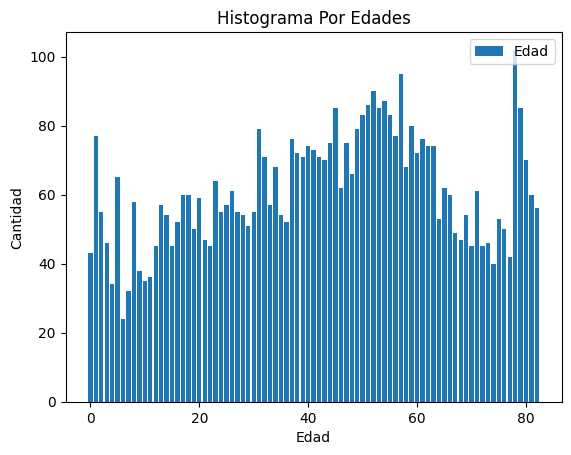

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


try:
    df04
except NameError:
    data = {"edad": [25, 30, 35, 25, 40, 30, 30, 25, 35, 40, 40, 25]}
    df04 = pd.DataFrame(data)

if isinstance(df04, pd.DataFrame):
    df_grouped = df04.groupby("edad").size().reset_index(name="cantidad")
    edades = df_grouped["edad"]
    cantidades = df_grouped["cantidad"]

elif "pyspark.sql.dataframe.DataFrame" in str(type(df04)):
    df_grouped = df04.groupBy("edad").count().orderBy("edad")
    df_pandas = df_grouped.toPandas()  # Convertir a Pandas
    edades = df_pandas["edad"]
    cantidades = df_pandas["count"]

else:
    raise TypeError("df04 no es un DataFrame válido de Pandas o PySpark")

plt.bar(edades, cantidades)
plt.ylabel("Cantidad")
plt.xlabel("Edad")
plt.title("Histograma Por Edades")
plt.legend(["Edad"], loc="upper right")

plt.show()

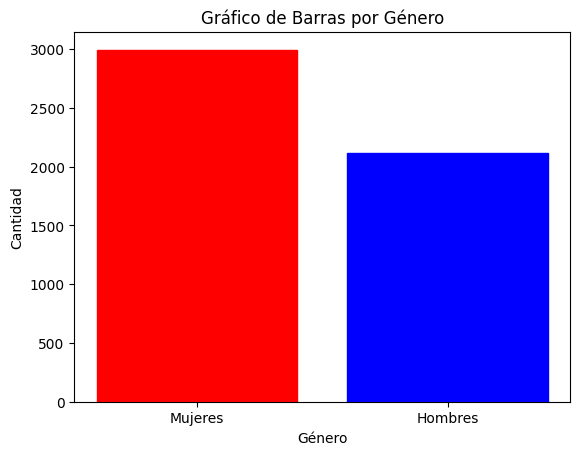

In [26]:
#Gráfica de género

# Filtrar los datos para eliminar el valor 'gender' y mantener solo 'Female' y 'Male'
df_filtered = df04.filter((col('genero') == 'Female') | (col('genero') == 'Male'))

# Obtener el conteo por grupo en la columna 'genero'
genero_count = df_filtered.groupby('genero').count().select('genero', 'count')

# Convertir a RDD y luego a lista para trabajar con ella
genero_count_list = genero_count.rdd.map(lambda x: (x[0], x[1])).collect()

# Separa las categorías y los conteos
categorias = ['Mujeres', 'Hombres']
cantidad = [x[1] for x in genero_count_list]
# Crear la gráfica de barras
grafica = plt.bar(categorias, cantidad)

grafica[0].set_color('r')
grafica[1].set_color('b')
plt.ylabel('Cantidad')
plt.xlabel('Género')
plt.title('Gráfico de Barras por Género')
plt.show()

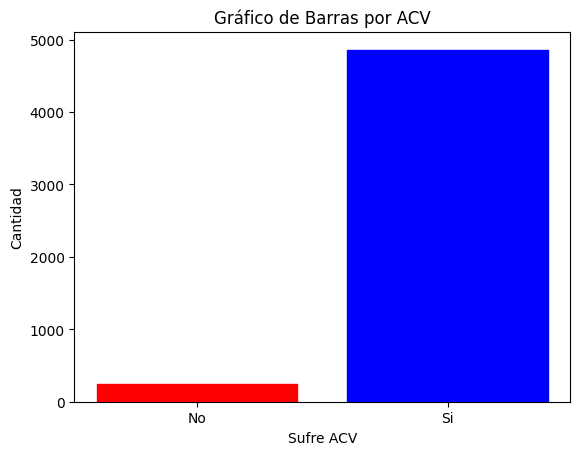

In [27]:
#Gráficas de enfermedades cardiacas

enfCardiaca = df04.groupBy('ACV').count().select('ACV', 'count')
# Filtrar los datos para eliminar el valor 'Stroke' y mantener solo '0' y '1'
enfCardiaca_filtered = enfCardiaca.filter((col('ACV') == 0) | (col('ACV') == 1))
# Convertir a RDD y luego a una lista
enfCardiaca_filtered = enfCardiaca_filtered.rdd.map(lambda x: (x[0], x[1])).collect()
# Separa los valores de las categorías y los conteos
categorias = ['No', 'Si']  # 'No' es 0 y 'Si' es 1
cantidad = [x[1] for x in enfCardiaca_filtered]
grafica = plt.bar(categorias, cantidad)
grafica[0].set_color('r')  # Colorea la barra para 'No' (0) en rojo
grafica[1].set_color('b')  # Colorea la barra para 'Si' (1) en azul
# Etiquetas y formato
plt.ylabel('Cantidad')
plt.xlabel('Sufre ACV')
plt.title('Gráfico de Barras por ACV')
plt.show()

# Modelado de Datos

In [34]:
# Se importan las librerias para idexar, ensamblaje, Pipeline, modelo de clasificación y Métrias (AUC-ROC)
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import roc_curve
import numpy as np

## Indexación y Pipeline

In [29]:
# Se indexan las variables categoricas
categorical_cols = ["genero", "EdoCivil", "trabajo", "Residencia", "Fumador"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx") for col in categorical_cols]

# Se crea el pipeline
pipeline = Pipeline(stages=indexers)
df04_indexed = pipeline.fit(df04).transform(df04)

# Se indexan las variables númericas + categoricas
feature_cols = ["edad", "hipertension", "enfCardiaca", "Niveldeglucosaprom", "IMC"] + [col+"_idx" for col in categorical_cols]

# Se ensablan las variables omitiendo nulls
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid='skip')
df04_final = assembler.transform(df04_indexed)

## Modelo Modelo de clasificación (Árbol de Decisión)

In [30]:
# Separar datos de entrenamiento y prueba
train, test = df04_final.randomSplit([0.8, 0.2], seed=13)

# Modelo de clasificación (Árbol de Decisión)
DTC = DecisionTreeClassifier(featuresCol="features", labelCol="ACV")
modelo = DTC.fit(train)

#Realizar predicciones
predictions = modelo.transform(test)
predictions.select("ACV", "prediction", "probability").show(10)

+---+----------+--------------------+
|ACV|prediction|         probability|
+---+----------+--------------------+
|  0|       0.0|[0.95679567956795...|
|  0|       0.0|[0.99797468354430...|
|  0|       0.0|[0.95679567956795...|
|  0|       0.0|[0.87081339712918...|
|  0|       0.0|[0.95679567956795...|
|  0|       0.0|[0.95679567956795...|
|  0|       0.0|[0.95679567956795...|
|  0|       0.0|[0.99797468354430...|
|  0|       0.0|[0.87081339712918...|
|  0|       0.0|[0.99797468354430...|
+---+----------+--------------------+
only showing top 10 rows



## Evaluación del Modelo (Métricas)

In [31]:
# Se crea una tabla para mostrar la matriz de confusión
conf_matrix = predictions.groupBy("ACV", "prediction").count() \
    .groupBy("ACV") \
    .pivot("prediction", [0, 1]) \
    .sum("count") \
    .na.fill(0) \
    .orderBy("ACV")
conf_matrix = conf_matrix.select(
    col("ACV").alias("Real"),
    col("0").alias("Predicho 0 (Negativo)"),
    col("1").alias("Predicho 1 (Positivo)")
)

conf_matrix.show()

+----+---------------------+---------------------+
|Real|Predicho 0 (Negativo)|Predicho 1 (Positivo)|
+----+---------------------+---------------------+
|   0|                  921|                    1|
|   1|                   49|                    1|
+----+---------------------+---------------------+



## Matriz de Confusión

**True Positives (TP)**
* N° de pacientes que sufrieron un paro cardíaco y el modelo predijo correctamente que SI lo sufrirían. El modelo identificó correctamente a pacientes con riesgo de ACV.

**True Negatives (TN)**
* N° de pacientes que NO sufrieron un paro cardíaco y el modelo predijo correctamente que NO lo sufrirían. El modelo identificó correctamente a pacientes sanas.

**False Positives (FP)**
*  N° de pacientes que NO sufrieron un paro cardíaco, pero el modelo predijo incorrectamente que SI lo sufrirían. Falsas alarmas: el modelo alertó riesgo en pacientes sanos.

**False Negatives (FN)**
* N° de pacientes que sí sufrieron un paro cardíaco , pero el modelo predijo incorrectamente que NO lo sufrirían. El modelo no detectó el riesgo de ACV.

In [32]:
# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="ACV", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="ACV", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="ACV", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="ACV", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)

# Mostrar resultados
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9486
Precision: 0.9264
Recall:    0.9486
F1 Score:  0.9255


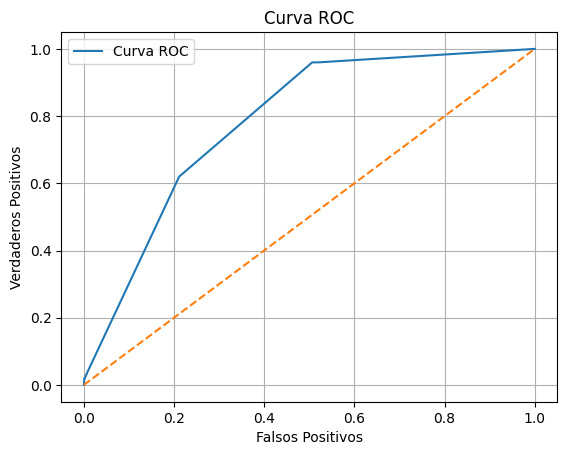

AUC-ROC = 78.0%


In [35]:
resultados = predictions.select("ACV", "probability").toPandas()
probabilidades = resultados['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(resultados['ACV'], probabilidades)

plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="ACV", metricName="areaUnderROC")
auc_roc_value = evaluator.evaluate(predictions)

print(f"AUC-ROC = {np.round(auc_roc_value, 2) * 100}%")

## Métricas
**1. Accuracy (Exactitud)**
* El porcentaje de pacientes que el modelo clasificó correctamente, ya sea que tuvieron o no un ACV. Si bien es una métrica muy útil e intuitiva, no es suficiente para afirmar que el modelo es o no óptimo en la resolución del problema.

* El resultado obtenido indica que el modelo es muy bueno clasificando entre pacientes sanos y con riesgo de ACV con una exactitud del **94.86%**.

**2. Precision (Precisión)**
* Es el porcentaje de pacientes alertados por el modelo de riesgo de ACV, cuántos efectivamente sufrieron un ACV. Una alta precisión en el modelo indica pocas falsas alarmas (FP).

* Para este problema resulta útil no alertar a un paciente sano y someterlo a pruebas innecesarias y costosas, sumado a la poca credibilidad de la **Institución de Salud o Médico en sus diagnosticos**.

* El resultado obtenido indica que el modelo es muy bueno identificando pacientes con riesgo de ACV con una precisión del **92.64%**.

**3. Recall (Sensibilidad o Tasa de verdaderos positivos)**
* Es el porcentaje de pacientes que tuvieron ACV y que el modelo detectó correctamente.

* Es la métrica más relevante en este problema, ya que es más critico que un paciente sufra un ACV y no detectarlo a tiempo por el modelo, que alertar falsamente a uno sano.

* El resultado obtenido indica que el modelo tiene una buena sensibilidad o TPR en los pacientes con riesgo de ACV con un Recall del **94.86%**.

**4. F1 Score**
* Es un punto medio entre precisión y recall, balanceando ambas métricas. Para este problema, considera tanto la capacidad del modelo para detectar correctamente los ACV (recall) como para evitar falsas alarmas (precisión).
* El resultado obtenido indica que el modelo hace un excelente equilibrio entre no perder casos reales y no alertar falsamente en un **92.55%**.

**5. AUC_ROC**
* La curva ROC muestra el equilibrio entre captar correctamente a los pacientes en riesgo (sensibilidad) y minimizar las falsas alarmas en pacientes sanos (especificidad) que un clasificador puede lograr al ajustar su umbral de decisión.
* El resultado obtenido indica que el modelo tiene un **78%** de probabilidad de asignar un puntaje de riesgo más alto a un paciente que realmente sufrió un ACV, en comparación con un paciente que no lo sufrió.
* La probabilidad obtenida es relativamente buena, si se deseara mejorarla, sería necesario cambiar el umbral de clasificación del modelo y evaluar cual de las métricas (sensibilidad o especificidad) se ha de priorizar en el modelo.

# Conclusiones

1. El modelo presenta desempeño equilibrado para clasificar pacientes con y sin riesgo de ACV, lo que indica que la mayoría de los pacientes son correctamente clasificados, tanto sanos como en riesgo.

2. La alta sensibilidad (recall) del modelo para detectar correctamente a los pacientes que sufrieron un ACV puede reducir significavamente el riesgo de los pacientes, lo cual es crítico en un contexto clínico, ya que evita que casos reales pasen desapercibidos.

3. El valor del AUC-ROC refleja un buen equilibrio entre sensibilidad y especificidad, señalando que el modelo es capaz de distinguir con bastante efectividad entre pacientes con y sin riesgo de ACV, aunque hay margen para ajustes en el umbral de clasificación que podrían optimizar aún más el desempeño según las prioridades clínicas.

